<h1><center>NFL BIG DATA BOWL 2020</center></h1>

# Summary

This notebook is an attempt to reproduce the winning solution of the "NFL Big data bowl 2020" competition hosted by Kaggle (https://www.kaggle.com/c/nfl-big-data-bowl-2020). In fact, the winning team discussed their approach and main ideas to solve this challenge [1], however, they didn't share the code implementation for their solution. 
Therefore, I'll attempt to reproduce:
- the data cleaning
- Feature engineering
- And model building steps based on the information available.

The goal of this competition is to predict how many yards will an NFL player (the rusher) gain after receiving the ball. For that, we'll use features known at the time when the ball is handed off  to the rusher and forecast the yardage gained on a specific play (PlayId).

To build the model, we'll assume that a rushing play consists of:

- A rusher, whose aim is to run forward as far as possible.
- 11 defense players who are trying to stop the rusher.
- 10 remaining offense players trying to prevent defenders from blocking or tackling the rusher.

This description already implies connections between which players are important and which might be less important.

# Outline

* [Load the data](#Load-the-data)
* [Data processing](#Data-processing)
* [Modeling approach](#Modeling-approach)
* [Converting a play into a 3D tensor](#Converting-a-play-into-a-3D-tensor)
* [Model architecture](#Model-architecture)

In [7]:
# Import packages

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import math

In [9]:
pd.set_option('max_columns', 100)

# Load the data

In [10]:
train = pd.read_csv('../input/train.csv', low_memory=False)

In [11]:
# Let's take a look at the data for a specific PlayId with the main columns of interest

In [12]:
cols = ['PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Dir', 'YardLine', 'PossessionTeam', 'NflIdRusher', 
        'PlayDirection', 'Yards', 'HomeTeamAbbr', 'VisitorTeamAbbr', 'FieldPosition']

#### Print data for a play

In [13]:
play_id = 20170907000118
train[cols].query('PlayId == @play_id')

,PlayId,Team,X,Y,S,A,Dis,Dir,YardLine,PossessionTeam,NflIdRusher,PlayDirection,Yards,HomeTeamAbbr,VisitorTeamAbbr,FieldPosition
0,20170907000118,away,73.91,34.84,1.69,1.13,0.40,177.18,35,NE,2543773,left,8,NE,KC,NE
1,20170907000118,away,74.67,32.64,0.42,1.35,0.01,198.70,35,NE,2543773,left,8,NE,KC,NE
2,20170907000118,away,74.00,33.20,1.22,0.59,0.31,202.73,35,NE,2543773,left,8,NE,KC,NE
3,20170907000118,away,71.46,27.70,0.42,0.54,0.02,105.64,35,NE,2543773,left,8,NE,KC,NE
4,20170907000118,away,69.32,35.42,1.82,2.43,0.16,164.31,35,NE,2543773,left,8,NE,KC,NE
5,20170907000118,away,75.06,24.00,1.01,0.32,0.18,95.01,35,NE,2543773,left,8,NE,KC,NE
6,20170907000118,away,74.11,16.64,1.11,0.83,0.02,322.59,35,NE,2543773,left,8,NE,KC,NE
7,20170907000118,away,73.37,18.73,1.24,0.74,0.13,270.04,35,NE,2543773,left,8,NE,KC,NE
8,20170907000118,away,56.63,26.90,0.26,1.86,0.28,55.31,35,NE,2543773,left,8,NE,KC,NE
9,20170907000118,away,73.35,38.83,4.55,0.76,0.51,190.84,35,NE,2543773,left,8,NE,KC,NE


# Data processing

- As we assume most people did, we adjusted the data to always be from left to right. Additionally, for training we clip the target to -30 and 50. For X,Y and Dir there is no other adjustment necessary, however, as most have noted, there are some issues with S and A. Apparently, the time frames were slightly different between different plays.

- For S, the best adjustment we found is to simply replace it with Dis * 10. A is a bit more tricky as there is apparently some form of leak in 2017 data (check the correlation between rusher A and target). So what we did is to adjust A by multiplying it with (Dis / S) / 0.1. That means we scale it similarly to how we scale S. After all, A only has a tiny signal after this adjustment, and one can easily drop it. As we rely on relative features in the model, we don’t apply any other standardization.

#### Some team names are not uniform across the data, let's fix them here

In [14]:
# create a dictionary of abbreviation to fix
map_abbr = {'ARI': 'ARZ', 'BAL': 'BLT', 'CLE': 'CLV', 'HOU': 'HST'}

# Add remaining abbreviations to the dictionary 
for abb in train['PossessionTeam'].unique():
    map_abbr[abb] = abb

# Fix abbreviations values    
train['PossessionTeam'] = train['PossessionTeam'].map(map_abbr)
train['HomeTeamAbbr'] = train['HomeTeamAbbr'].map(map_abbr)

#### Create a binary variable indicating whether a player is the ball carrier

In [15]:
train['IsRusher'] = (train.NflId == train.NflIdRusher)

#### Transform the data so that the offensive team always moves in the same direction (left to right)

In a football game teams switch sides every quarter, the dataset provides a feature 'PlayDirection' that indicates whether a play is moving left to right or right to left.

We need to transform the data so that the offensive team always moves in the same direction (left to right) so that the input features are more consistent for training.

In [16]:
# Create a binary variable for plays moving left to right (ToLeft)
train['ToLeft'] = (train.PlayDirection == "left")

In [17]:
# Create a variable indicating which team is the offensive team (home vs away)

# Initialize TeamOnOffense to "home"
train['TeamOnOffense'] = "home" 

# Set TeamOnOffense to "away" when PossessionTeam is not equal to HomeTeamAbbr
train.loc[train.PossessionTeam != train.HomeTeamAbbr, 'TeamOnOffense'] = "away"

# Create an indicator variable
train['IsOnOffense'] = (train.Team == train.TeamOnOffense)

In [18]:
# On the graph we can see that X is almost symmetrical distribution with a mean around 60. 
# This symmetry is due to the fact that X depends on PlayDirection and PlayDirection takes on two values, either right or left.

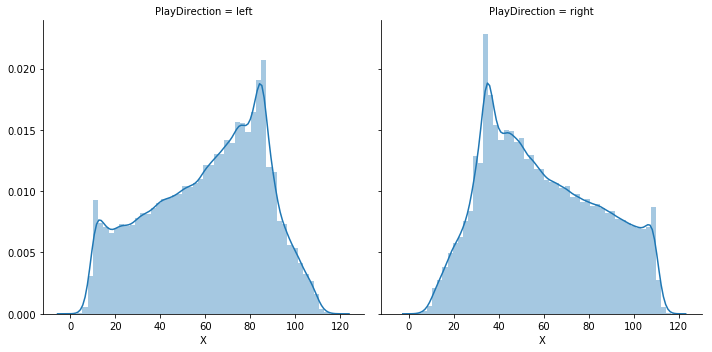

In [19]:
g = sns.FacetGrid(data=train, col='PlayDirection', height=5, aspect=1)
g.map(sns.distplot, 'X')

In [20]:
# Let's convert X so that the offensive team always left to right

In [21]:
train.loc[train.PlayDirection=='left', 'X'] = 120 - train.loc[train.PlayDirection=='left', 'X']

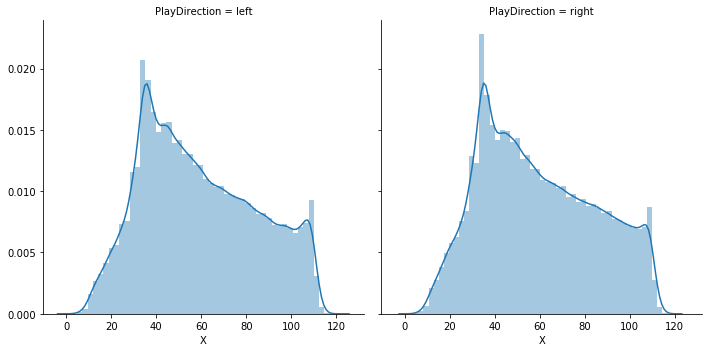

In [22]:
# Let's check the graph again
g = sns.FacetGrid(data=train, col='PlayDirection', height=5, aspect=1)
g.map(sns.distplot, 'X')

After the conversion, X is consistent whether PlayDirection is left or right. Therefore, the offensive team is moving left to right all the time.

### Make YardLine consistent when PossesssionTeam is different from FieldPosition

In [23]:
train['IsPosTeamInFieldPos'] = (train['PossessionTeam'] == train['FieldPosition'])

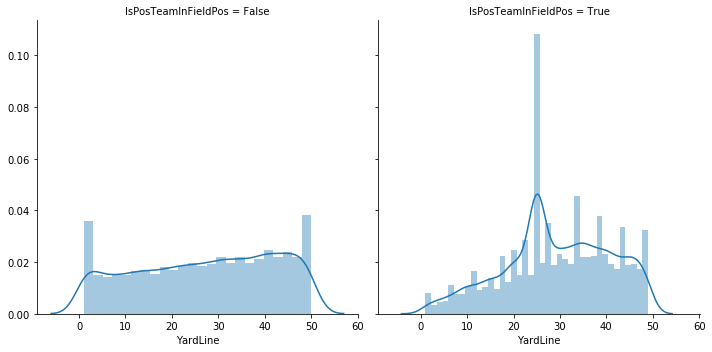

In [24]:
# Let's check the graph again
mask = (train['IsRusher']==True)
g = sns.FacetGrid(data=train[mask], col='IsPosTeamInFieldPos', height=5, aspect=1)
g.map(sns.distplot, 'YardLine')

When the play is happening in the defensive team side of the field, the line of scrimmage 'YardLine' should be larger than 50 yards.
We can see from the graph on the right that we need to subtract 'YardLine' from 100 to make the conversion.

In [25]:
# Convert YardLine
mask = (train['PossessionTeam'] != train['FieldPosition'])
train.loc[mask, 'YardLine'] = 100 - train.loc[mask, 'YardLine']

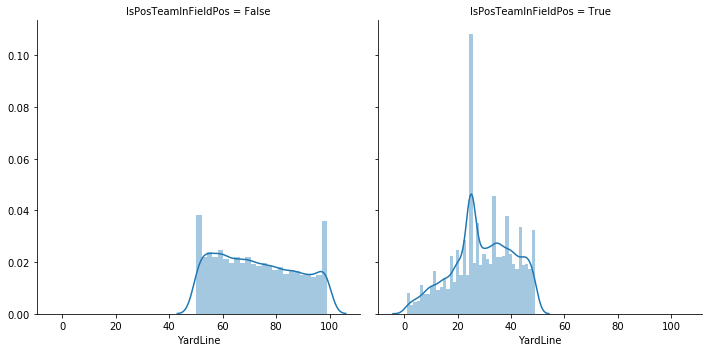

In [26]:
# Let's check the graph again
mask = (train['IsRusher']==True)
g = sns.FacetGrid(data=train[mask], col='IsPosTeamInFieldPos', height=5, aspect=1)
g.map(sns.distplot, 'YardLine')

Ok, YardLine looks good after the conversion; it ranges from 0 to 50 when PossessionTeam is in its side of the field and from 50 to 100 when PossessionTeam is in its opponent side.

# Plot the football field to visualize the offensive/defensive teams as well as the line of scrimmage [3].

In [27]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

No handles with labels found to put in legend.


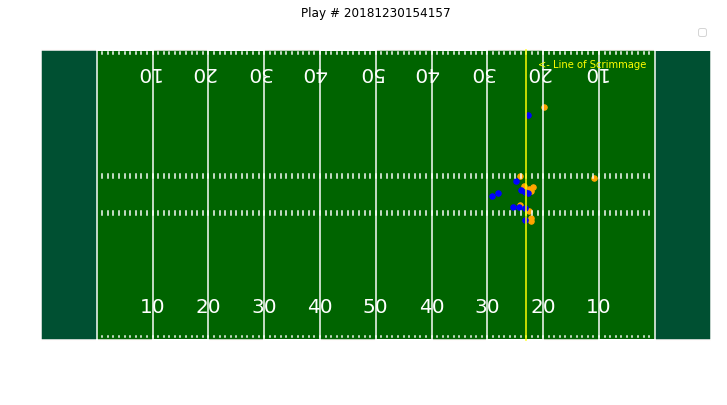

In [28]:
playid = 20181230154157
#20170907000345
#20181230154157

yl = train.query("PlayId == @playid")['YardLine'].tolist()[0]
fig, ax = create_football_field(highlight_line=True, highlight_line_number=yl)
train.query("PlayId == @playid and Team == 'away'").plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=30, legend='Away')
train.query("PlayId == @playid and Team == 'home'").plot(x='X', y='Y', kind='scatter', ax=ax, color='blue', s=30, legend='Home')
plt.title(f'Play # {playid}')
plt.legend()
plt.show()

### The target variable is provided by the feature 'Yards'. Let's look at its distribution.

In [29]:
# The target to predict is 'Yards' feature for the rusher.
target = train.loc[train.IsRusher==True, 'Yards']

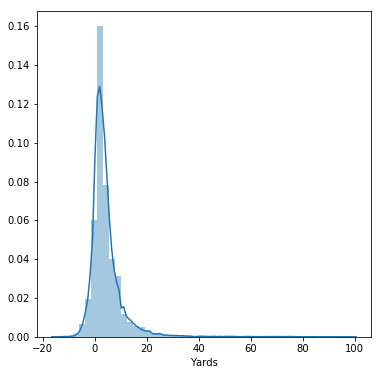

In [30]:
# Let's plot the distribution of the target variable
fig, ax = plt.subplots(figsize=(6,6))
sns.distplot(target)

In [31]:
target.describe()

count    31007.000000
mean         4.227626
std          6.449966
min        -15.000000
25%          1.000000
50%          3.000000
75%          6.000000
max         99.000000
Name: Yards, dtype: float64

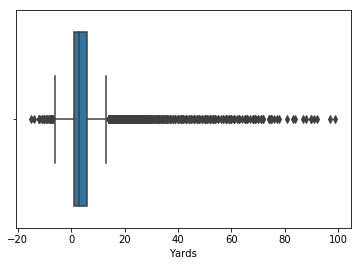

In [32]:
sns.boxplot(target)

In [33]:
# Print the percentage of values for different ranges of the target variable
intrvl = [-10, -5, 0, 5, 10,20,30,40,50,60,70,80,90, 100]
i=-15
total = target.shape[0]
for j in intrvl:
    pct = round(target.loc[target.between(i,j)].shape[0] / total * 100, 2)
    print(f"% of target value between {i} and {j}: {pct} %")
    i = j

% of target value between -15 and -10: 0.05 %
% of target value between -10 and -5: 0.9 %
% of target value between -5 and 0: 19.59 %
% of target value between 0 and 5: 63.6 %
% of target value between 5 and 10: 23.96 %
% of target value between 10 and 20: 8.51 %
% of target value between 20 and 30: 1.68 %
% of target value between 30 and 40: 0.45 %
% of target value between 40 and 50: 0.2 %
% of target value between 50 and 60: 0.16 %
% of target value between 60 and 70: 0.09 %
% of target value between 70 and 80: 0.05 %
% of target value between 80 and 90: 0.02 %
% of target value between 90 and 100: 0.02 %


In [34]:
# It seems unlikely that the rusher will run more than 50 yards so we'll set the target variable to a maximum of 50
train.loc[train.Yards > 50 ,'Yards'] = 50

### Converting Speed 'S' using the distance 'Dis'

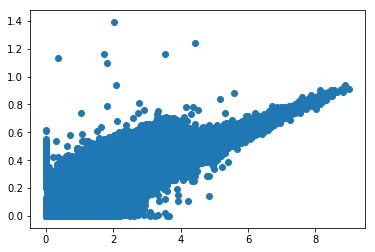

In [35]:
# Converting Speed 'S' using the Distance column; distance is defined as yards traveled in 0.1 second
# For some reason, S is slightly off for 2017 data compared to 2018
mask = (train['Season']==2017)
plt.scatter(train['S'][mask].values, train['Dis'][mask].values)

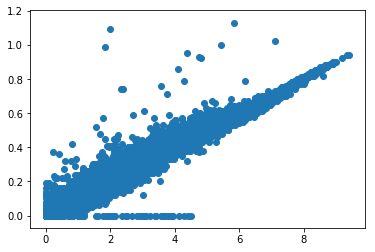

In [36]:
mask = (train['Season']==2018)
plt.scatter(train['S'][mask].values, train['Dis'][mask].values)

In [37]:
# Let's replace S by Dis * 10 as Dis is defined as yards traveled in 0.1 seconds.
train['S'] = train['Dis'] * 10

### Normalize the direction 'Dir' of a player (angle in which a player is moving)

We're going to normalize Dir as follows [2]:

* 0 degrees: the offensive player is moving completely to his left
* 90 degrees: the offensive player is moving straight ahead, towards opponent end zone
* 180 degrees: the offensive player is moving completely to his right
* 270 degrees: the offensive player is moving backwards, towards his own team's end zone (this is generally bad)

'Dir' provides the angle in which a player is moving, and PlayDirection tells us which direction the play is headed.
Let's plot 'Dir' by 'PlayDirection'.

In [38]:
train_rusher = train.loc[train['IsRusher']==True,:]

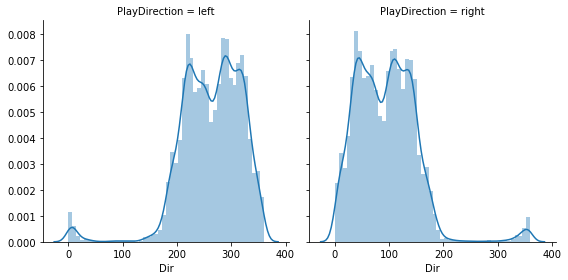

In [39]:
g = sns.FacetGrid(data=train_rusher, col='PlayDirection', height=4, aspect=1)
g.map(sns.distplot, 'Dir')

On plays to the left, angles are clustered between 180 and 360, with a handful of angles around 0 to 15 degrees. This can be tricky -- 5 degrees should be treated like 365 degrees, even though it doesn't show up that way in the data. Similarly, among players moving to the right PlayDirection == "right", there are a handful of player angles around 350 degrees with most players facing between 0 and 180 degrees. 

Let's make these values more consistent.

In [40]:
mask = (train['PlayDirection']=='left') & (train['Dir'] < 90)
train['Dir_clean'] = train['Dir'].copy(deep=True)
train.loc[mask, 'Dir_clean'] = train.loc[mask, 'Dir_clean'] + 360

mask = (train['PlayDirection']=='right') & (train['Dir'] > 270)
train.loc[mask, 'Dir_clean'] = train.loc[mask, 'Dir_clean'] - 360

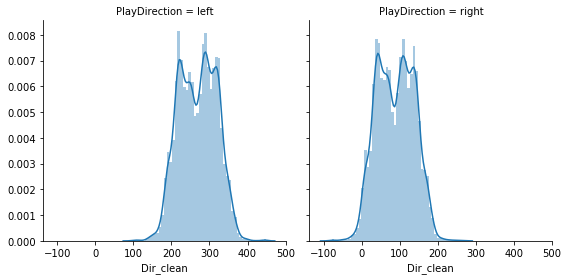

In [41]:
mask = (train['IsRusher']==True)
train_rusher = train.loc[mask,:]

g = sns.FacetGrid(data=train_rusher, col='PlayDirection', height=4, aspect=1)
g.map(sns.distplot, 'Dir_clean')

The two charts look more symmetrical now.

To make 'Dir' consistent regardless of PlayDirection, we need to subtract 180 from 'Dir' when PlayDirection == left. 

In [42]:
train.loc[train.PlayDirection=='left', 'Dir_clean'] = train.loc[train.PlayDirection=='left', 'Dir_clean']-180

In [43]:
# Let's plot final results for Dir_clean

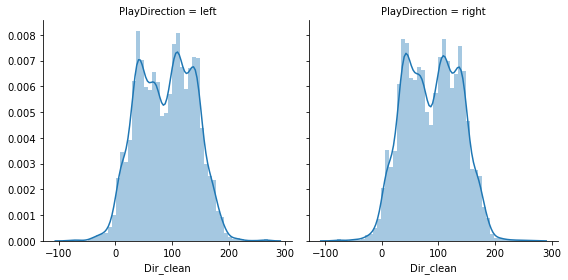

In [44]:
mask = (train['IsRusher']==True)
train_rusher = train.loc[mask,:]

g = sns.FacetGrid(data=train_rusher, col='PlayDirection', height=4, aspect=1)
g.map(sns.distplot, 'Dir_clean')

We can see that the graphs are symmetrical and the values are distributed in the same range.

### Convert angles to radians (this will be useful when calculating cosine and sine)

In [45]:
# Convert angles to radians
train['DirRadians']  = train['Dir_clean'] * np.pi / 180

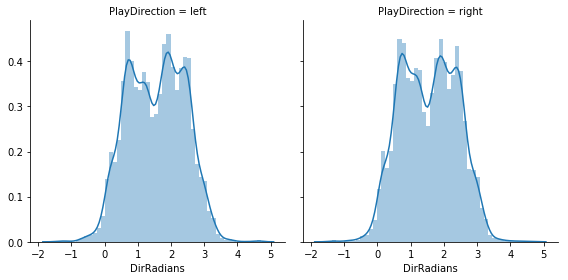

In [46]:
# Plot angles in radians as a sanity check
mask = (train['IsRusher']==True)
train_rusher = train.loc[mask,:]

g = sns.FacetGrid(data=train_rusher, col='PlayDirection', height=4, aspect=1)
g.map(sns.distplot, 'DirRadians')

### Let's plot players Speed and Direction (in radians) to confirm the changes we made

In [47]:
def get_Sx_Sy(angle, speed):
    """ Function to project of Speed and Direction (angle in radians) on X and Y axis
    """
    Sx = speed * math.cos(angle)
    Sy = speed * math.sin(angle)
    return Sx, Sy

No handles with labels found to put in legend.


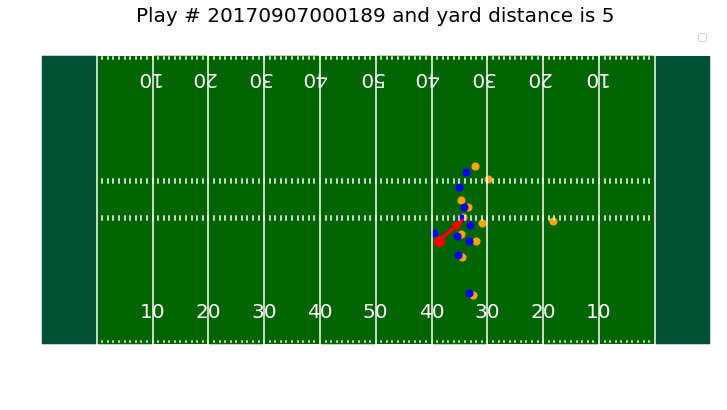

In [48]:
# Select a specific play_id
play_id = 20170907000189

fig, ax = create_football_field()
# Plot the away team players in orange
train.query("PlayId == @play_id and Team == 'away'").plot(x='X', y='Y', kind='scatter', ax=ax, color='orange', s=50, legend='Away')
# Plot the away team players in blue
train.query("PlayId == @play_id and Team == 'home'").plot(x='X', y='Y', kind='scatter', ax=ax, color='blue', s=50, legend='Home')
# Plot the rusher in red
train.query("PlayId == @play_id and NflIdRusher == NflId").plot(x='X', y='Y', kind='scatter', ax=ax, color='red', s=100, legend='Rusher')

# Get rusher data
rusher_data = train.query("PlayId == @play_id and NflIdRusher == NflId")
yards_covered = rusher_data["Yards"].values[0]

# Get rusher X and Y coordinates
x = rusher_data["X"].values[0]
y = rusher_data["Y"].values[0]

# Get rusher direction in radians (angle)
rusher_dir = rusher_data["DirRadians"].values[0]

# Get rusher speed
rusher_speed = rusher_data["S"].values[0]

# Project rusher speed and direction on the X and Y axis
Sx, Sy = get_Sx_Sy(rusher_dir, rusher_speed)

ax.arrow(x, y, Sx, Sy, length_includes_head=True, width=0.5, color='red')
plt.title(f'Play # {play_id} and yard distance is {yards_covered}', fontsize=20)
plt.legend()
plt.show()

**The red arrow shows the direction in which the rusher is headed, and the length of the arrow indicates his speed.**

# Modeling approach

**As our goal is to predict how many yards will the rusher (in red) gain after receiving the ball, we'll assume that a rushing play consists of:**

- **A rusher, whose aim is to run forward as far as possible.**

- **11 defense players who are trying to stop the rusher.**
- **10 remaining offense players trying to prevent defenders from blocking or tackling the rusher.**

**This description already implies connections between which players are important and which might.**

If we focus on the rusher and remove other offense team players, it looks like a simple game where one player tries to run away and 11 others try to catch him. We assume that as soon as the rushing play starts, every defender regardless of the position, will focus on stopping the rusher asap and every defender has a chance to do it. The chances of a defender to tackle the rusher (as well as estimated location of the tackle) depend on their relative location, speed and direction of movements.

That points to the idea of a **convolution over individual defenders using relative locations and speeds, and then applying pooling on top.**

To include the offense team player we follow the same logic - these 10 players will try to block or tackle any of the defender if there is a risk of getting the rusher stopped. So, to assess the position of a defender we want to go through all the offense team players, use their location and speed relative to the defender, and then aggregate. To do so, we apply **convolution and pooling again.**

## Converting a play into a 3D tensor

**Each play is converted into a 3D tensor with the following shape 11x10x10.**
The 3 dimensions correspond to: 11 defenders x 10 offense players x 10 numeric features that we're going to create from the original data:

<img src="images/3D_tensor.png">

**The numeric features are listed below:**
1. Sx: defender's speed projected on X axis. It is constant across the offense axis. 
2. Sy: defender's speed projected on Y axis. It is constant across the offense axis.
3. Def_X - Rush_X: Defender's X coordinate relative to rusher (constant across the offense axis).
4. Def_Y - Rush_Y: Defender's Y coordinate relative to rusher (constant across the offense axis).
5. Def_Sx - Rush_Sx: Sx relative to rusher (constant across the offense axis).
6. Def_Sy - Rush_Sy: Sy relative to rusher (constant across the offense axis).
7. Defender's X coordinate relative to each offense player except the rusher.
8. Defender's Y coordinate relative to each offense player except the rusher.
9. Defender's Sx relative to each offense player except the rusher.
10. Defender's Sy relative to each offense player except the rusher.

#### Create new feature vectors for the model on sample data

In [51]:
def get_defender_relative_coord(df):
    """
    Function to get defender's X and Y relative to the rusher for a specific play.
    """
    # Get rusher X and Y
    rushX = df.loc[df.IsRusher==True,'X'].values[0]
    rushY = df.loc[df.IsRusher==True,'Y'].values[0]
    
    # Loop through defenders and compute relative coordinates X and Y
    def_X = df.loc[df.IsOnOffense==False]['X'].apply(lambda x : x - rushX)
    def_Y = df.loc[df.IsOnOffense==False]['Y'].apply(lambda x : x - rushY)    
    
    # Return results
    return def_X, def_Y

In [52]:
def get_Sx_Sy(angle, speed):
    """
    Function to get the projection of Speed and Angle on X and Y axis for a player.
    """
    Sx = speed * math.cos(angle)
    Sy = speed * math.sin(angle)
    return Sx, Sy

In [156]:
def get_defenders_vs_offense_features(df):
    """
    Function to get defenders features relative to offense players
    """
    
    def_rel_X = []
    def_rel_Y = []
    def_rel_Sx = []
    def_rel_Sy = []

    for def_row in df.loc[df.IsOnOffense==False,].iterrows():
        # Get defender X and Y
        def_X = def_row[1]['X']
        def_Y = def_row[1]['Y']
        # Get defender Sx and Sy
        def_Sx = get_Sx_Sy(angle=def_row[1]['DirRadians'], speed=def_row[1]['S'])[0]
        def_Sy = get_Sx_Sy(angle=def_row[1]['DirRadians'], speed=def_row[1]['S'])[1]

        # Loop through offense team except the rusher and compute defender's relative coordinates
        mask = (df.IsOnOffense==True) & (df.IsRusher==False)
        for off_row in df.loc[mask,].iterrows():
            # Get offensive player X and Y
            off_X = off_row[1]['X']
            off_Y = off_row[1]['Y']

            # Get offensive player Sx and Sy
            off_Sx = get_Sx_Sy(angle=off_row[1]['DirRadians'], speed=def_row[1]['S'])[0]
            off_Sy = get_Sx_Sy(angle=off_row[1]['DirRadians'], speed=def_row[1]['S'])[1]

            # Compute defender relative X, Y, Sx and Sy
            def_rel_X.append(def_X - off_X)
            def_rel_Y.append(def_Y - off_Y)
            def_rel_Sx.append(def_Sx - off_Sx)
            def_rel_Sy.append(def_Sy - off_Sy)

    # Convert lists to arrays
    def_rel_X = np.array(def_rel_X).reshape(11,10)
    def_rel_Y = np.array(def_rel_Y).reshape(11,10)
    def_rel_Sx = np.array(def_rel_Sx).reshape(11,10)
    def_rel_Sy = np.array(def_rel_Sy).reshape(11,10)    
       
    return def_rel_X, def_rel_Y, def_rel_Sx, def_rel_Sy

In [174]:
def create_def_rusher_features(df):
    """
    Function to get defenders Sx, Sy as well their features relative to the rusher
    """
    # Create Sx channel
    Sx = np.array(df.loc[df.IsOnOffense==False][['DirRadians', 'S']].apply(lambda x : get_Sx_Sy(angle=x[0], speed=x[1])[0], axis=1))

    # Create Sy channel
    Sy = np.array(df.loc[df.IsOnOffense==False][['DirRadians', 'S']].apply(lambda x : get_Sx_Sy(angle=x[0], speed=x[1])[1], axis=1))
    
    # Create X coordinate relative to rusher (constant across the offense axis).
    def_rel_X = np.array(get_defender_relative_coord(df)[0])
    
    # Create Y coordinate relative to rusher (constant across the offense axis).
    def_rel_Y = np.array(get_defender_relative_coord(df)[1])
   
    # Get rusher Sx and Sy
    rush_Sx = np.array(df.loc[df.IsRusher==True][['DirRadians', 'S']].apply(lambda x : get_Sx_Sy(angle=x[0], speed=x[1])[0], axis=1))
    rush_Sy = np.array(df.loc[df.IsRusher==True][['DirRadians', 'S']].apply(lambda x : get_Sx_Sy(angle=x[0], speed=x[1])[1], axis=1))
       
    # Compute defender Sx and Sy relative to rusher (constant across the offense axis).
    def_rel_Sx = Sx - rush_Sx
    def_rel_Sy = Sy - rush_Sy
    
    return Sx, Sy, def_rel_X, def_rel_Y, def_rel_Sx, def_rel_Sy

In [180]:
def create_play_tensor(df):
    """
    Function to create the 3D tensor for a specific play
    """
                
    # get defender and "defender vs rusher" features
    result = np.repeat(create_def_rusher_features(test),repeats=10, axis=0).reshape(11,10,6)
    
    # Compute defenders coordinates and speed relative to each offense team player except the rusher
    def_vs_off_arrays = get_defenders_vs_offense_features(df)
    
    # Loop through def_vs_off_arrays and concatenate values to result following axis 2
    for arr in def_vs_off_arrays:
        arr = arr.reshape(11, 10, 1)
        result = np.concatenate((result, arr), axis=2)
    
    # Make sure the result is of shape (11, 10, 10)
    assert result.shape == (11, 10, 10)
        
    return result

#### Test functions on a specific play

In [49]:
cols = ['PlayId', 'Team', 'X', 'Y', 'S', 'DirRadians',  'NflId', 'NflIdRusher',  'Yards', 'IsRusher', 'PlayDirection', 'IsOnOffense']
test = train[cols].copy(deep=True)

In [50]:
play_id = 20170907000118

test = test.query('PlayId == @play_id')
test

,PlayId,Team,X,Y,S,DirRadians,NflId,NflIdRusher,Yards,IsRusher,PlayDirection,IsOnOffense
0,20170907000118,away,46.09,34.84,4.0,-0.049218,496723,2543773,8,False,left,False
1,20170907000118,away,45.33,32.64,0.1,0.326377,2495116,2543773,8,False,left,False
2,20170907000118,away,46.00,33.20,3.1,0.396713,2495493,2543773,8,False,left,False
3,20170907000118,away,48.54,27.70,0.2,-1.297827,2506353,2543773,8,False,left,False
4,20170907000118,away,50.68,35.42,1.6,-0.273842,2530794,2543773,8,False,left,False
5,20170907000118,away,44.94,24.00,1.8,-1.483355,2543494,2543773,8,False,left,False
6,20170907000118,away,45.89,16.64,0.2,2.488665,2543637,2543773,8,False,left,False
7,20170907000118,away,46.63,18.73,1.3,1.571494,2543851,2543773,8,False,left,False
8,20170907000118,away,63.37,26.90,2.8,4.106934,2550257,2543773,8,False,left,False
9,20170907000118,away,46.65,38.83,5.1,0.189194,2552488,2543773,8,False,left,False


In [182]:
# Test create_play_tensor function
create_play_tensor(test).shape

(11, 10, 10)

This looks good, we get the expected shape after creating new features from the data for a specific play.

# Model architecture

<img src="images/model_structure.png">

**TODO: Add description of the model.**
<br>
<br>

In [ ]:
input_dense_players = Input(shape=(11,10,10), name = "numerical_players_feature_input")

x = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation=None)(input_dense_players)

x = Activation('relu')(x)

x = Conv2D(160, kernel_size=(1,1), strides=(1,1), activation=None)(x)

x = Activation('relu')(x)

x = Conv2D(128, kernel_size=(1,1), strides=(1,1), activation=None)(x)

x = Activation('relu')(x)

xmax = MaxPooling2D(pool_size=(1,10))(x)

xmax = Lambda(lambda x1 : x1*0.3)(xmax)

xavg = AvgPool2D(pool_size=(1,10))(x)

xavg = Lambda(lambda x1 : x1*0.7)(xavg)

x = Add()([xmax, xavg])

x = Lambda(lambda y : K.squeeze(y,2))(x)

x = Conv1D(128, kernel_size=1, strides=1, activation=None)(x)

x = Activation('relu')(x)

x = BatchNormalization()(x)

x = Conv1D(160, kernel_size=1, strides=1, activation=None)(x)

x = Activation('relu')(x)

x = BatchNormalization()(x)

x = Conv1D(96, kernel_size=1, strides=1, activation=None)(x)

x = Activation('relu')(x)

x = BatchNormalization()(x)

xmax = MaxPooling1D(pool_size=11)(x)

xmax = Lambda(lambda x1 : x1*0.3)(xmax)

xavg = AvgPool1D(pool_size=11)(x)

xavg = Lambda(lambda x1 : x1*0.7)(xavg)

x = Add()([xmax, xavg])

x = Lambda(lambda y : K.squeeze(y,1))(x)

x = Dense(96)(x)

x = Activation('relu')(x)

x = BatchNormalization()(x)

x = Dense(256, activation="relu")(x)

x = Activation('relu')(x)

x = BatchNormalization()(x)

out_reg = Dense(1, activation='relu', name = "main_op_2")(x)

out_soft = Dense(199, activation='softmax', name = "main_op_1")(x)

model = Model(inputs = [input_dense_players], outputs = [out_soft, out_reg])

# TODO  - create a generator to convert data on the fly and train the model

# References

- [1] https://www.kaggle.com/c/nfl-big-data-bowl-2020/discussion/119400
- [2] https://www.kaggle.com/statsbymichaellopez/nfl-tracking-wrangling-voronoi-and-sonars
- [3] https://www.kaggle.com/robikscube/nfl-big-data-bowl-plotting-player-position